In [1]:
%matplotlib inline
import sys
sys.path.append('/apps')
import django
django.setup()
from drivers.graph_models import TreeNode, Order, Family, graph, pickNode
from traversals.strategies import sumTrees, UniformRandomSampleForest

# GPFlow first approximation

In [2]:
## Import modules
import numpy as np
import scipy.spatial.distance as sp
from matplotlib import pyplot as plt
plt.style.use('ggplot')

## Simulating Data
* Simulate random uniform 4-d vector. Give N of this.

In [3]:
## Parameter definitions
N = 1000
phi = 0.05
sigma2 = 1.0
beta_0 = 10.0
beta_1 = 1.5
beta_2 = -1.0
# AL NAGAT
nugget = 0.03

In [4]:
X = np.random.rand(N,4)

* Calculate distance
X can be interpreted as covariate matrix in which the first two columns are the longitud and latitude.
GPFlow requires that all the covariates (including spatio-temporal coordinates) are in X.



In [5]:
points = X[:,0:2]
dist_points = sp.pdist(points)

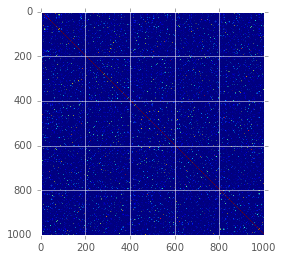

In [6]:
## Reshape the vector to square matrix 
distance_matrix = sp.squareform(dist_points)
correlation_matrix  = np.exp(- distance_matrix / phi)
covariance_matrix = correlation_matrix * sigma2
plt.imshow(covariance_matrix)

## Simulate the Gaussian Process $S$

Remmember that for a stationary Gaussian Process, the value at Z is independent of the betas (Covariate weights).
Mean 0's $\Sigma$ Correlation matrix
$$S = MVN(0,\Sigma) + \epsilon$$
$ \epsilon \sim N(0,\sigma^{2}) $

S is a realization of a spatial process.

In [7]:
S = np.random.multivariate_normal(np.zeros(N), correlation_matrix) +\
        np.random.normal(size = N) * nugget

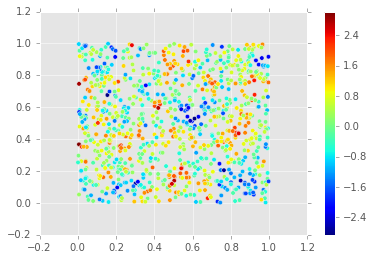

In [8]:
S.shape
# We convert to Matrix [1 column]
S = S.reshape(N,1)
## Plot x, y using as color the Gaussian process
plt.scatter(X[:, 0], X[:, 1], c = S)
plt.colorbar()

* Simulate the Response Variable $y$     

$$y_1(x_1,x_2) = S(x_1,x_2) $$
$$y_2(x_1,x_2) = \beta_0 + x_3\beta_1 + x_4\beta_2 + S(x_1,x_2)$$

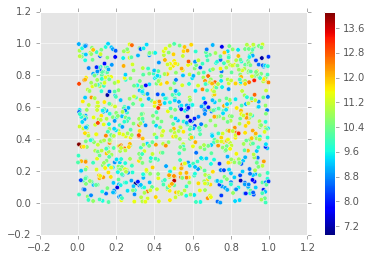

In [9]:
# remmember index 0 is 1
mu = beta_0 + beta_1 * X[:, 2] + beta_2 * X[:, 3]
mu = mu.reshape(N,1)
Y1 = S
Y2 = mu + S
plt.scatter(X[:, 0], X[:, 1], c = Y2)
plt.colorbar()

In [10]:
S.shape

(1000, 1)

# GP Model !
This model is without covariates

In [14]:
# Import GPFlow
import GPflow as gf

In [15]:
# Defining the model Matern function with \kappa = 0.5 
k = gf.kernels.Matern12(2, lengthscales=1, active_dims = [0,1] )

In [16]:
type(k)

GPflow.kernels.Matern12

## Model for $y_1$

In [17]:
m = gf.gpr.GPR(points, Y1, k)
## First guess
init_nugget = 0.001
m.likelihood.variance = init_nugget
print(m)

name.kern.lengthscales transform:+ve prior:None
[ 1.]
name.kern.variance transform:+ve prior:None
[ 1.]
name.likelihood.variance transform:+ve prior:None
[ 0.001]



* Like in tensorflow, m is a graph and has at least three nodes: *lengthscale, kern variance and likelihood variance*

In [18]:
# Estimation using symbolic gradient descent
m.optimize()
print(m)

name.kern.lengthscales transform:+ve prior:None
[ 0.04899438]
name.kern.variance transform:+ve prior:None
[ 1.0912394]
name.likelihood.variance transform:+ve prior:None
[  1.04964184e-06]



compare with original parameters (made from the simulation)

In [19]:
print(phi,sigma2,nugget)

(0.05, 1.0, 0.03)


In [23]:
print points.shape
print Y1.shape

(1000, 2)
(1000, 1)


 it was close enough

## GAUSSIAN PROCESS WITH LINEAR TREND 
### Defining the model

In [179]:
k = gf.kernels.Matern12(2, lengthscales=1, active_dims = [0,1] )

In [180]:
gf.mean_functions.Linear()
meanf = gf.mean_functions.Linear(np.ones((4,1)), np.ones(1))

In [181]:
m = gf.gpr.GPR(X, Y2, k, meanf)
m.likelihood.variance = init_nugget
print(m)

name.kern.lengthscales transform:+ve prior:None
[ 1.]
name.kern.variance transform:+ve prior:None
[ 1.]
name.likelihood.variance transform:+ve prior:None
[ 0.001]
name.mean_function.A transform:(none) prior:None
[[ 1.]
 [ 1.]
 [ 1.]
 [ 1.]]
name.mean_function.b transform:(none) prior:None
[ 1.]


In [182]:
# Estimation
m.optimize()
print(m)

name.kern.lengthscales transform:+ve prior:None
[ 0.05029038]
name.kern.variance transform:+ve prior:None
[ 0.98037623]
name.likelihood.variance transform:+ve prior:None
[ 0.0059287]
name.mean_function.A transform:(none) prior:None
[[ 0.44958183]
 [ 0.03042917]
 [ 1.52097183]
 [-0.97419863]]
name.mean_function.b transform:(none) prior:None
[ 9.60799153]


### Original parameters
* phi = 0.05  ---> lengthscale
* sigma2 = 1.0 ---> variance transform
* nugget = 0.03 ---> likelihood variance
* beta_0 = 10.0 ---> mean_function b
* beta_1 = 1.5 ---> mean_fucntionA [2]
* beta_2 = -1.0 ---> mean_functionA [3]
* mean_functionA[0] and mean_functionA[1] are the betas for for x and y (coordinates respectively)


### Without spatial coordinates as covariates

In [15]:
# Defining the model
k = gf.kernels.Matern12(2, lengthscales=1, active_dims = [0,1])

##### Custom made mean function (Erick Chacón )

In [16]:
from GPflow.mean_functions import MeanFunction, Param
import tensorflow as tf
class LinearG(MeanFunction):
    """
    y_i = A x_i + b
    """
    def __init__(self, A=None, b=None):
        """
        A is a matrix which maps each element of X to Y, b is an additive
        constant.
        If X has N rows and D columns, and Y is intended to have Q columns,
        then A must be D x Q, b must be a vector of length Q.
        """
        A = np.ones((1, 1)) if A is None else A
        b = np.zeros(1) if b is None else b
        MeanFunction.__init__(self)
        self.A = Param(np.atleast_2d(A))
        self.b = Param(b)

    def __call__(self, X):
        Anew = tf.concat([np.zeros((2,1)),self.A],0)
        return tf.matmul(X, Anew) + self.b


### Now we can use the special mean function *without* the coordinates (covariates).

In [17]:
meanf = LinearG(np.ones((2,1)), np.ones(1))

In [1]:
X.shape
Y2.shape

NameError: name 'X' is not defined

In [18]:
m = gf.gpr.GPR(X, Y2, k, meanf)a
m.likelihood.variance = 0.1
print(m)

name.kern.lengthscales transform:+ve prior:None
[ 1.]
name.kern.variance transform:+ve prior:None
[ 1.]
name.likelihood.variance transform:+ve prior:None
[ 0.1]
name.mean_function.A transform:(none) prior:None
[[ 1.]
 [ 1.]]
name.mean_function.b transform:(none) prior:None
[ 1.]


### Only 2 parameters now!

In [19]:
# Estimation
m.optimize()
print(m)

name.kern.lengthscales transform:+ve prior:None
[ 0.05198912]
name.kern.variance transform:+ve prior:None
[ 1.08595541]
name.likelihood.variance transform:+ve prior:None
[  1.04187191e-06]
name.mean_function.A transform:(none) prior:None
[[ 1.47377333]
 [-1.12897884]]
name.mean_function.b transform:(none) prior:None
[ 10.28939636]


### Original parameters
* phi = 0.05  ---> lengthscale
* sigma2 = 1.0 ---> variance transform
* nugget = 0.03 ---> likelihood variance
* beta_0 = 10.0 ---> mean_function b
* beta_1 = 1.5 ---> mean_fucntionA [2]
* beta_2 = -1.0 ---> mean_functionA [3]

In [188]:
predicted_x = np.linspace(0.0,1.0,100)

In [189]:
from external_plugins.spystats.models import makeDuples
predsX = makeDuples(predicted_x)

In [190]:
pX = np.array(predsX)

In [191]:
tt = np.ones((10000,2)) *0.5

In [192]:
## Concatenate with horizontal stack
SuperX = np.hstack((pX,tt))

In [193]:
SuperX.shape

(10000, 4)

In [194]:
mean, variance = m.predict_y(SuperX)
minmean = min(mean)
maxmean = max(mean)

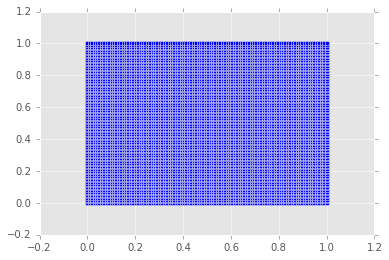

In [195]:
#plt.figure(figsize=(12, 6))
plt.scatter(pX[:,0], pX[:,1])


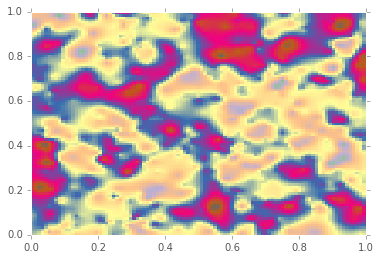

In [208]:
Xx, Yy = np.meshgrid(predicted_x,predicted_x)
plt.pcolor(Xx,Yy,mean.reshape(100,100),cmap=plt.cm.Accent)

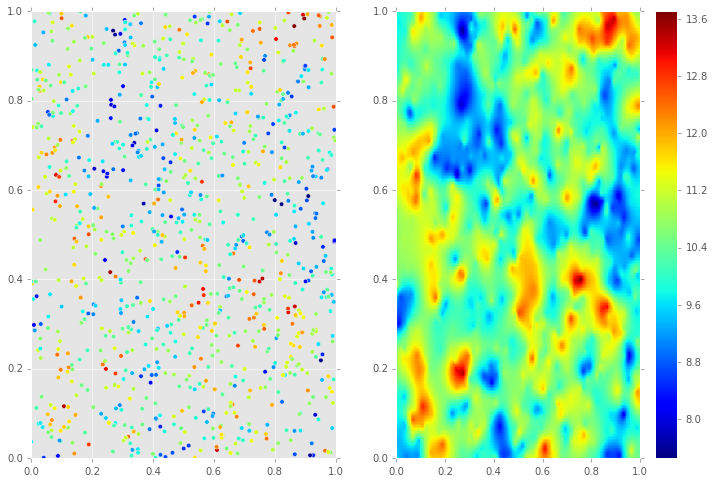

In [20]:
Nn = 300
predicted_x = np.linspace(0.0,1.0,Nn)
Xx, Yy = np.meshgrid(predicted_x,predicted_x)
## Predict
from external_plugins.spystats.models import makeDuples
predsX = makeDuples(predicted_x)
pX = np.array(predsX)
tt = np.ones((Nn**2,2)) *0.5
SuperX = np.hstack((pX,tt))
mean, variance = m.predict_y(SuperX)
minmean = min(mean)
maxmean = max(mean)
width = 12
height = 8
minz = minmean
maxz = maxmean
plt.figure(figsize=(width, height))
plt.subplot(1,2,1)
scat = plt.scatter(X[:, 0], X[:, 1], c = Y2)
#plt.axis('equal')
plt.xlim((0,1))
plt.ylim((0,1))
plt.clim(minz,maxz)
#plt.colorbar()
plt.subplot(1,2,2)
#field = plt.imshow(mean.reshape(100,100).transpose().transpose(),interpolation=None)
plt.pcolor(Xx,Yy,mean.reshape(Nn,Nn).transpose())
plt.colorbar()
plt.clim(minz,maxz)





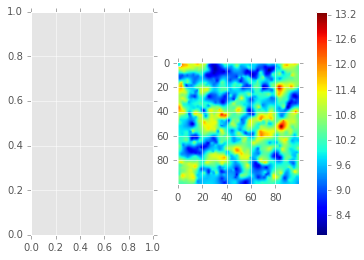

In [132]:
fig, axes = plt.subplots(nrows=1, ncols=2)
scat = plt.scatter(X[:, 0], X[:, 1], c = Y2)

field = plt.imshow(mean.reshape(100,100),interpolation=None)
#fig.subplots_adjust(right=0.8)
#cbar_ax = fig.add_axes([0.85, 0.05])
fig.colorbar(field, ax=axes.ravel().tolist())



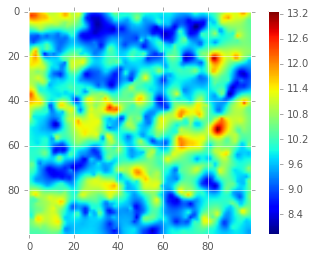

In [106]:
plt.imshow(mean.reshape(100,100),interpolation=None)
plt.colorbar()